# Setup a game

In [1]:
from ConnectN import ConnectN

game_setting = {'size':(3,3), 'N':3}
game = ConnectN(**game_setting)

In [2]:
help(game)

Help on ConnectN in module ConnectN object:

class ConnectN(builtins.object)
 |  Methods defined here:
 |  
 |  __copy__(self)
 |      Fast deepcopy.
 |  
 |  __init__(self, size, N, pie_rule=False)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  available_mask(self)
 |      Returns a grid that resembles the board, where 0s represent
 |      available spaces and 1 unavailable spaces.
 |  
 |  available_moves(self)
 |      Returns the indices of the available spaces.
 |  
 |  get_score(self)
 |      Check victory condition (fast version).
 |  
 |  get_winning_loc(self)
 |      Returns the winning line indices.
 |  
 |  move(self, loc)
 |      Tries to make a suggested next move.
 |      Args:
 |          loc: A suggested next move.
 |      
 |      Returns:
 |          True if the suggested next move is made successfully.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |

In [3]:
game.move((0,1))
print("Game state: \n{}".format(game.state))
print("Next player: {}".format(game.player))
print("Current score: {}".format(game.score))

Game state: 
[[0. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Next player: -1
Current score: None


In [4]:
# player -1 move
game.move((0,0))
# player +1 move
game.move((1,1))
# player -1 move
game.move((1,0))
# player +1 move
game.move((2,1))

print("Game state: \n{}".format(game.state))
print("Next player: {}".format(game.player))
print("Current score: {}".format(game.score))

Game state: 
[[-1.  1.  0.]
 [-1.  1.  0.]
 [ 0.  1.  0.]]
Next player: 1
Current score: 1


# Play a game interactively

<IPython.core.display.Javascript object>


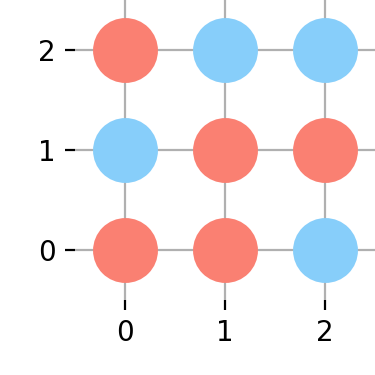

In [5]:
% matplotlib notebook

from ConnectN import ConnectN
from Play import Play

game_setting = {'size':(3,3), 'N':3}
gameplay=Play(ConnectN(**game_setting), 
              player1=None, 
              player2=None)

# Initialize an AI to play the game
We need to define a policy for tic-tac-toe, that takes the game state as input, and outputs a policy and a critic

## Tentative Exercise:
Code up your own policy for training

In [6]:
from math import *
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F


class Policy(nn.Module):
    """The policy takes the game state as input and outputs a policy and a critic.
    
    Returns:
        tuple: actions, probabilities. 
    """
    def __init__(self):
        super(Policy, self).__init__()
        
        self.conv = nn.Conv2d(1, 16, kernel_size=2, stride=1, bias=False)
        self.size = 2*2*16
        self.fc = nn.Linear(self.size,32)

        # layers for the policy
        self.fc_action1 = nn.Linear(32, 16)
        self.fc_action2 = nn.Linear(16, 9)
        
        # layers for the critic
        self.fc_value1 = nn.Linear(32, 8)
        self.fc_value2 = nn.Linear(8, 1)
        self.tanh_value = nn.Tanh()
        
    def forward(self, x):
        y = F.relu(self.conv(x))
        y = y.view(-1, self.size)
        y = F.relu(self.fc(y))
              
        # the action head
        a = F.relu(self.fc_action1(y))
        a = self.fc_action2(a)
        
        # availability of moves, 0s at locations where actions are impossible
        avail = (torch.abs(x.squeeze())!=1).type(torch.FloatTensor)
        avail = avail.view(-1, 9)
        
        # subtract off max for numerical stability (avoids blowing up at infinity)
        maxa = torch.max(a)
        exp = avail * torch.exp(a - maxa)
        prob = exp / torch.sum(exp)
        
        # the value head
        value = F.relu(self.fc_value1(y))
        value = self.tanh_value(self.fc_value2(value))
        
        return prob.view(3,3), value

policy = Policy()

## Define a player that uses MCTS and the expert policy + critic to play a game

We've introduced a new parameter
$T$ = temperature

This tells us how to choose the next move based on the MCTS results

$$p_a = \frac{N_a^{\frac{1}{T}}}{\sum_a N_a^{\frac{1}{T}}}$$

$T \rightarrow 0$, we choose action with largest $N_a$. 

In [8]:
from copy import copy
import random

import MCTS


def Policy_Player_MCTS(game):
    mytree = MCTS.Node(copy(game))
    for _ in range(50):
        mytree.explore(policy)
   
    mytreenext, (v, nn_v, p, nn_p) = mytree.next(temperature=0.1)
    print("\tv: {}\n\tnn_v: {}\n\tp: {}\n\tnn_p: {}".format(
        v, nn_v, p, nn_p))
        
    return mytreenext.game.last_move

def Random_Player(game):
    return random.choice(game.available_moves())    

In [9]:
game = ConnectN(**game_setting)
print(game.state)
Policy_Player_MCTS(game)
game.move((1,1))
print(game.state)
Policy_Player_MCTS(game)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
	v: 0.06314310852833893
	nn_v: 0.2688460946083069
	p: tensor([ 1.3828e-13,  1.3828e-13,  1.3828e-13,  1.5204e-01,  1.3828e-13,
         1.4848e-04,  8.4781e-01,  1.3828e-13,  1.3828e-13])
	nn_p: tensor([ 0.0947,  0.1055,  0.1181,  0.1271,  0.0985,  0.1244,  0.1298,
         0.0845,  0.1174])
[[0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]]
	v: 0.0864957907566562
	nn_v: 0.3027130961418152
	p: tensor([ 6.8933e-13,  6.8933e-13,  6.8933e-13,  7.5793e-01,  4.2682e-02,
         1.9939e-01,  6.8933e-13,  4.0704e-08])
	nn_p: tensor([ 0.1019,  0.1179,  0.1285,  0.1443,  0.1393,  0.1453,  0.0911,
         0.1316])


(1, 0)

# Play a game against the policy

<IPython.core.display.Javascript object>


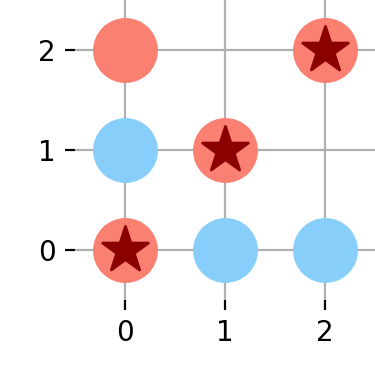

In [10]:
% matplotlib notebook


gameplay=Play(ConnectN(**game_setting), 
              player1=None, 
              player2=Policy_Player_MCTS)

# Training Loop

In [11]:
# initialize our alphazero agent and optimizer
import torch.optim as optim

game = ConnectN(**game_setting)
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=.01, weight_decay=1.e-4)

## Tenative exercise:
code up the alphazero loss function, defined to be
$$L = \sum_t \left\{ (v^{(t)}_\theta - z)^2  - \sum_a p^{(t)}_a \log \pi_\theta(a|s_t) \right\} + \textrm{constant}$$ 
I added a constant term $\sum_t \sum_a p^{(t)}\log p^{(t)}$ so that when $v_\theta^{(t)} = z$ and $p^{(t)}_a = \pi_\theta(a|s_t)$, $L=0$, this way we can have some metric of progress.

In [12]:
from collections import deque
import MCTS

episodes = 400
outcomes = []
losses = []

!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episodes).start()

for e in range(episodes):

    mytree = MCTS.Node(ConnectN(**game_setting))
    vterm = []
    logterm = []
    
    while mytree.outcome is None:
        for _ in range(50):
            mytree.explore(policy)

        current_player = mytree.game.player
        mytree, (v, nn_v, p, nn_p) = mytree.next()        
        mytree.detach_mother()
        
        # compute prob * log pi 
        loglist = torch.log(nn_p) * p
        
        # constant term to make sure if policy result = MCTS result, loss = 0
        constant = torch.where(p > 0, p * torch.log(p), torch.tensor(0.))
        logterm.append(-torch.sum(loglist - constant))
        
        vterm.append(nn_v * current_player)
        
    # we compute the "policy_loss" for computing gradient
    outcome = mytree.outcome
    outcomes.append(outcome)

    loss = torch.sum( (torch.stack(vterm)-outcome)**2 + torch.stack(logterm) )
    optimizer.zero_grad()

    loss.backward()
    losses.append(float(loss))
    optimizer.step()
    
    if (e+1)%50==0:
        print("game: ", e+1, 
              ", mean loss: {:3.2f}".format(np.mean(losses[-20:])),
              ", recent outcomes: ", outcomes[-10:])
    del loss
    
    timer.update(e+1)
    
timer.finish()

game:  50 , mean loss: 6.36 , recent outcomes:  [1, 0, -1, 0, 0, 1, 1, 0, 0, 0]


game:  100 , mean loss: 6.05 , recent outcomes:  [0, 1, 0, 0, 1, 1, 1, 0, 0, 1]


game:  150 , mean loss: 4.71 , recent outcomes:  [0, 1, 0, 0, 0, 0, -1, 0, 0, 0]


game:  200 , mean loss: 3.81 , recent outcomes:  [1, 0, 0, 0, 1, 0, 0, 0, 1, 1]


game:  250 , mean loss: 2.11 , recent outcomes:  [0, 0, 1, 0, 0, 1, 0, 1, 0, 0]


game:  300 , mean loss: 3.30 , recent outcomes:  [-1, 0, 0, 0, 1, 0, 0, 0, 0, 0]


game:  350 , mean loss: 4.62 , recent outcomes:  [0, 0, 0, 0, -1, 0, 1, 0, 0, 1]


game:  400 , mean loss: 2.66 , recent outcomes:  [0, -1, 0, 0, 0, 0, 0, 0, 1, 0]


<IPython.core.display.Javascript object>


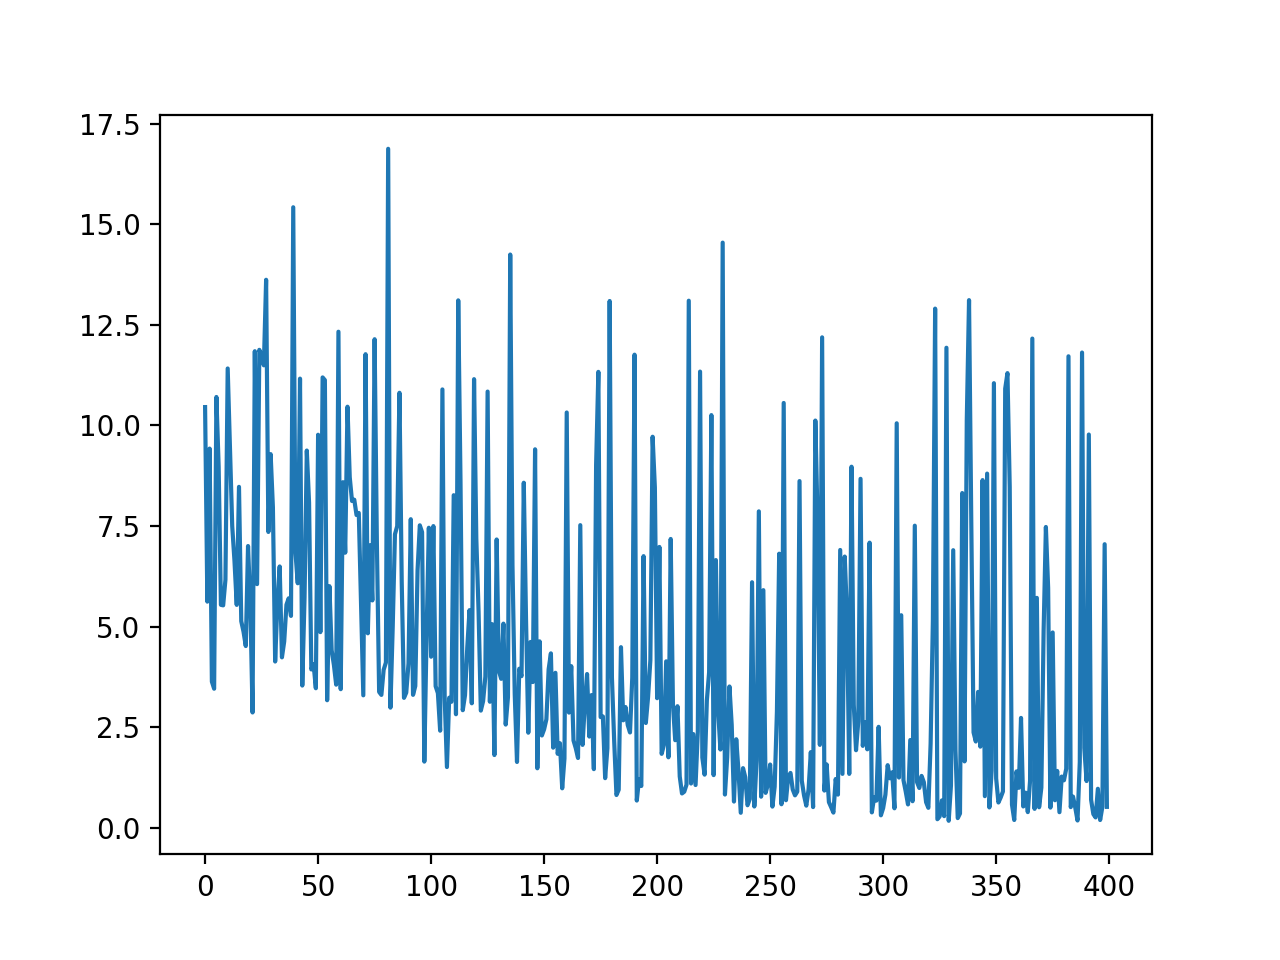

In [13]:
# plot your losses

import matplotlib.pyplot as plt

% matplotlib notebook
plt.plot(losses)
plt.show()

# Play a game against your alphazero agent !

<IPython.core.display.Javascript object>


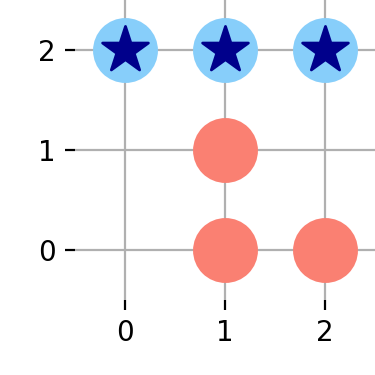

In [14]:
% matplotlib notebook

# as first player
gameplay=Play(ConnectN(**game_setting), 
              player1=None, 
              player2=Policy_Player_MCTS)

<IPython.core.display.Javascript object>


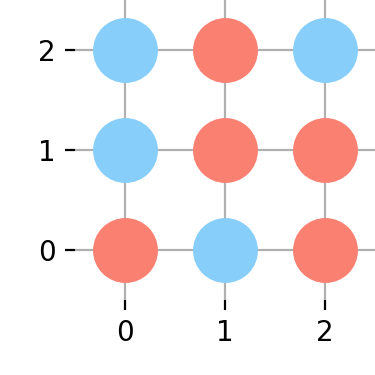

	v: 0.006413024108428875
	nn_v: -0.01385701633989811
	p: tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,
         0.0000,  0.0000])
	nn_p: tensor([ 0.0024,  0.0010,  0.0017,  0.0030,  0.9860,  0.0018,  0.0009,
         0.0017,  0.0016])


In [15]:
% matplotlib notebook

# as second player

gameplay=Play(ConnectN(**game_setting), 
              player2=None, 
              player1=Policy_Player_MCTS)